# Tutorial 11: Transit search

You will learn how to use allesfitter's wrapper around "wotan" and "transit_least_squares" (tls) to find exoplanets even in chaotic light curves!

## 1) Load and inspect the data

First, let's load the light curve. Here, we will use one from previous tutorials, which you can download here.


In [1]:
from allesfitter import read_csv
time, flux, flux_err = read_csv('Leonardo.csv'); #replace with your light curve

Let's check how this light curve looks like:

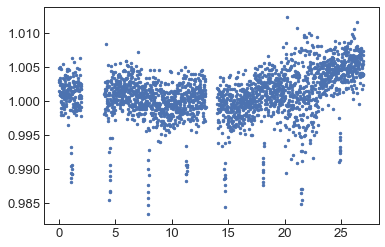

In [2]:
from allesfitter import plot_csv
plot_csv('Leonardo.csv');

## 2) A simple (default) transit search

Nice! We can see the transits by eye, but we also see quite some systematic noise in there. 
Let's see what we find if we just run a transit search without any other information:

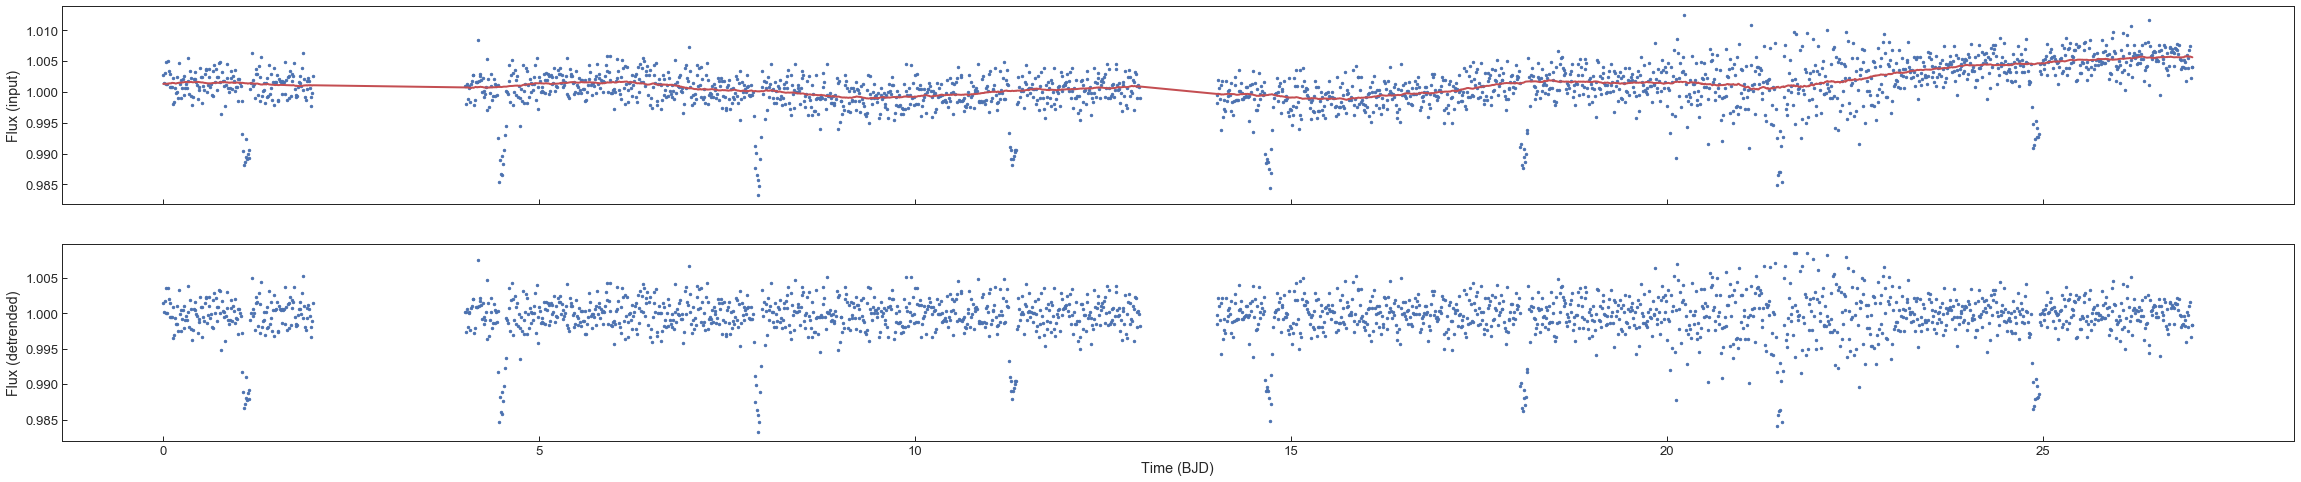

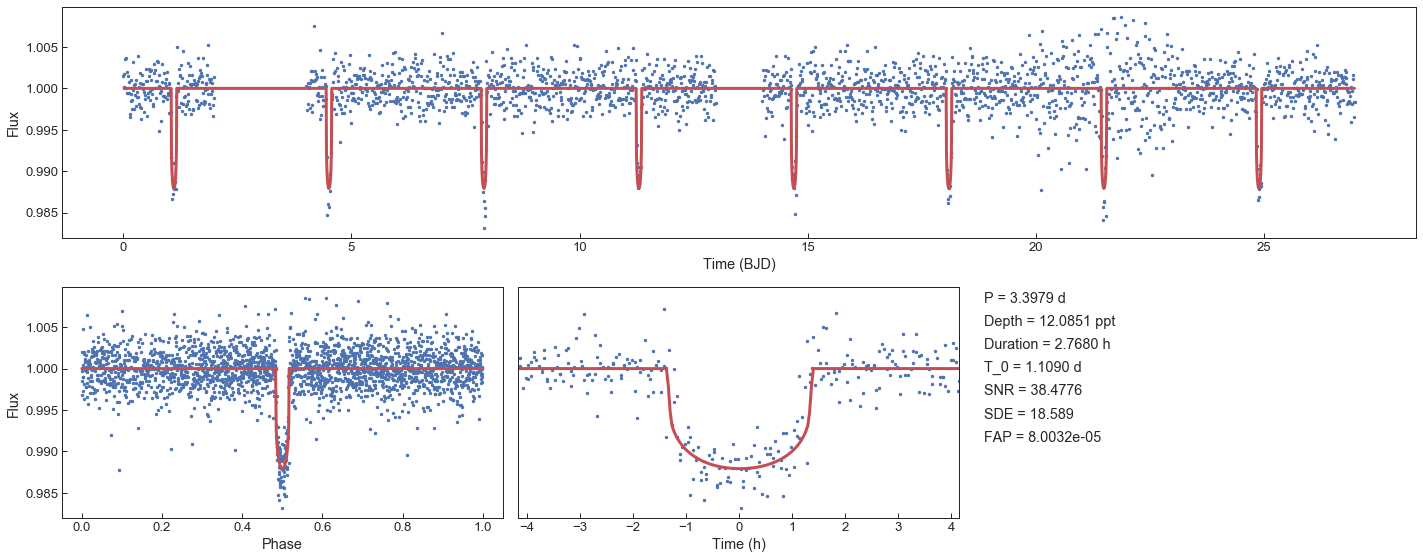

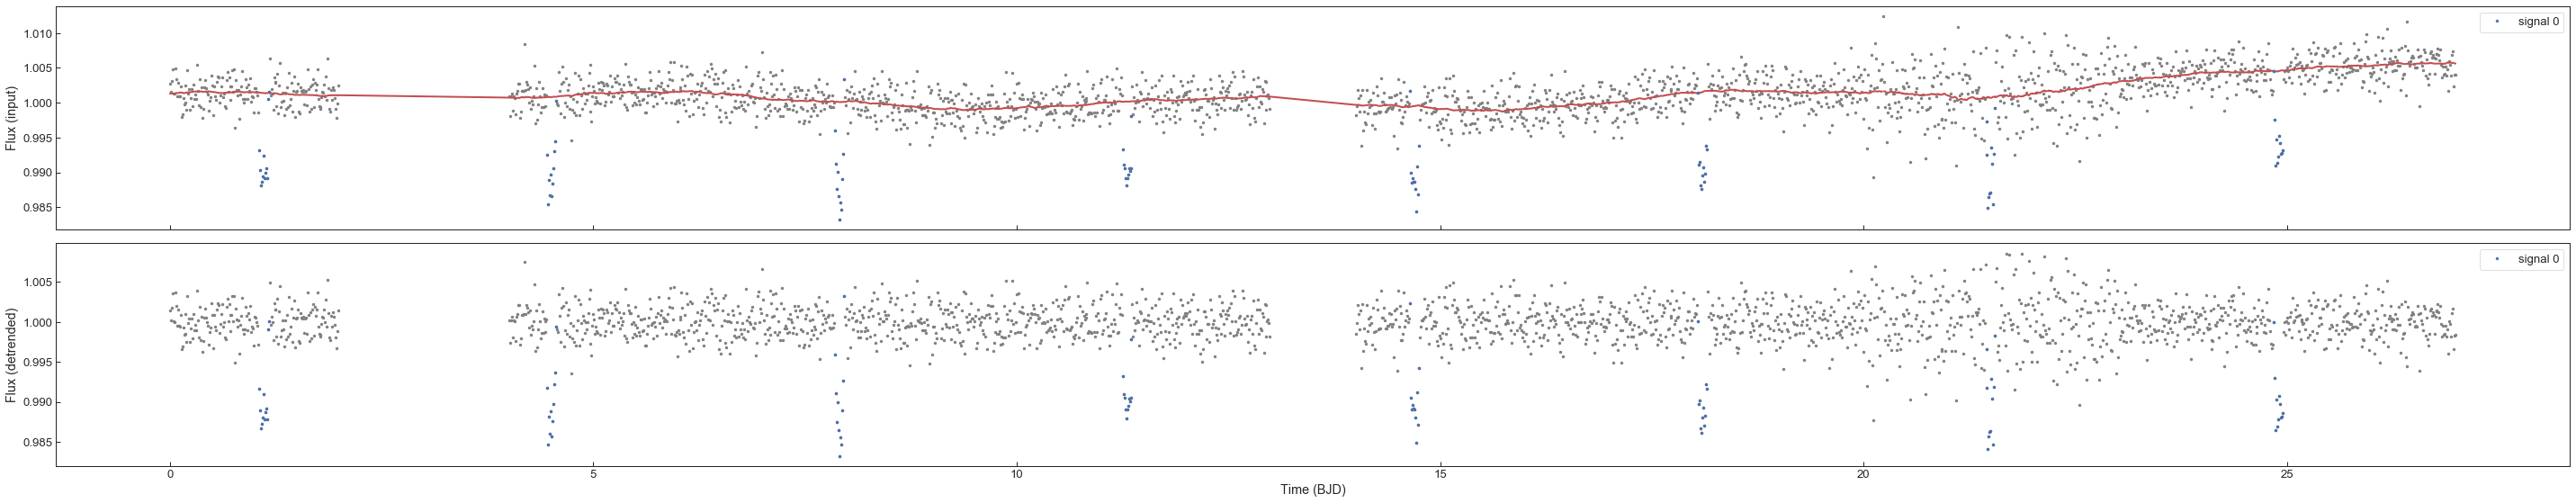

In [3]:
from allesfitter.detection.transit_search import tls_search
tls_search(time, flux, flux_err);

You will see three figures now. 
(1) The first figure (two rows) one shows you the full light curve, the detrending, and the resulting detrended light curve. 
(2) The second figure (two rows) shows you the light curve with a model fit, the phase folded light curve with model fit, and a zoom onto the transit with model fit, along with some infos like the period, depth, duration, etc.
(3) The third figure is a bit useless here, but will be useful for multi-planet systems, I promise! It shows the same as the first figure, but now with color-coding of all the different planets.

If you check the folder you ran this notebook in, you will also see a new results folder called "tls_results_biweight_1.0". Open and explore it! You will find summary files and all details in there. 

## 3) Enhance and fine-tune your exoplanet search (if you wish)

### 3.1) Enhance the transit-least-squares (TLS) search by using the right transit shapes

The big beauty of TLS lies in the fact that you can use the exact predicted transit shapes to search for (rather than boxes or the like).
As you know, planet transit shapes can look very different, depending on the bodies' sizes, orbits and the stellar limb darkening. Thus, it is quite important that we inform our TLS search by passing those parameters into it!
Here is how we do it, assuming the host star in our example has a radius of 1.0+-0.1 Rstar, a mass of 1.0+-0.1 Msun, and limb darkening parameters of [0.6,0.4]:

In [4]:
tls_kwargs = {}    
tls_kwargs['R_star']=1.0 #here 1.0 Rsun
tls_kwargs['R_star_min']=0.7 #3 sigma lower bound, here 1.0 Rsun - 3 * 0.1 Rsun = 0.7 Rsun
tls_kwargs['R_star_max']=1.3 #3 sigma upper bound, here 1.0 Rsun + 3 * 0.1 Rsun = 1.3 Rsun
tls_kwargs['M_star']=1.0 #here 1.0 Msun
tls_kwargs['M_star_min']=0.7 #3 sigma lower bound, here 1.0 Msun - 3 * 0.1 Msun = 0.7 Msun
tls_kwargs['M_star_max']=1.3 #3 sigma upper bound, here 1.0 Msun + 3 * 0.1 Msun = 1.3 Msun
tls_kwargs['u']=[0.6,0.4]

... and I will also quickly do this, don't worry about it for now:

In [5]:
 options={'show_plot':'2'}; #for simplicity, let's look only at the second figure(s) this time

... and now let's pass this into our function and re-do our search:

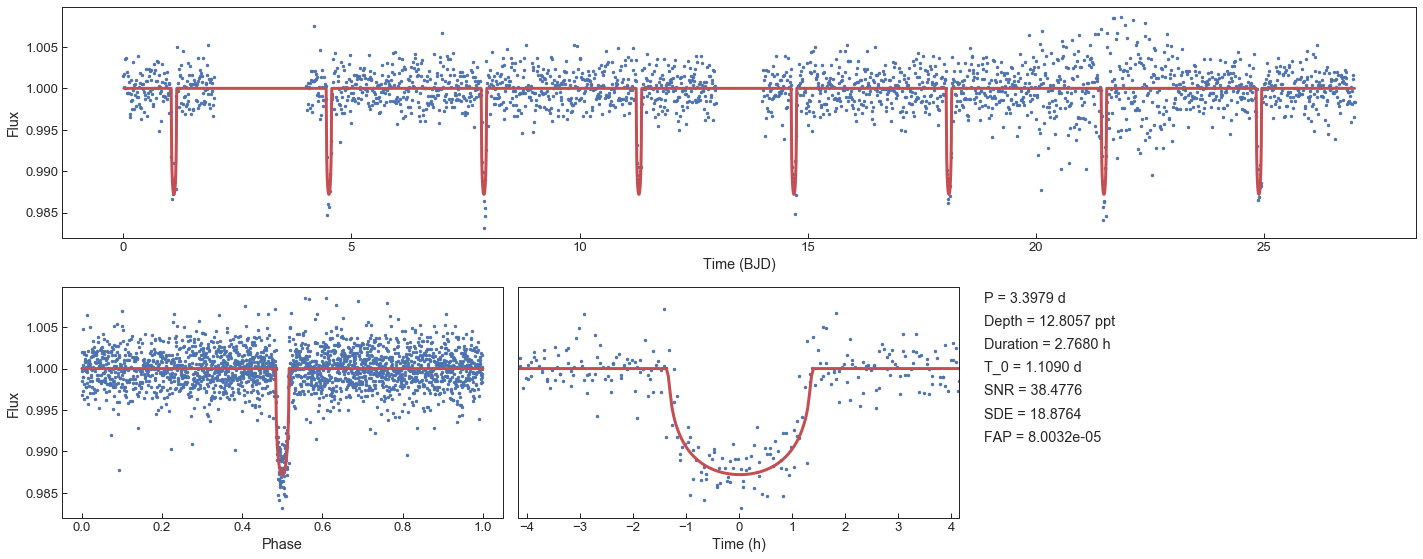

In [6]:
tls_search(time, flux, flux_err, tls_kwargs=tls_kwargs, options=options);

We did it again! Look at us!
Now, where do we get these stellar infos from, if no mysterious documentation writer gives them to us?
For TESS, the answer is build into wotan and allesfitter shamelessly draws from that. For the example of TOI-270 (TIC 259377017) just do this:

In [7]:
from allesfitter.detection.transit_search import get_tls_kwargs_by_tic
tls_kwargs = get_tls_kwargs_by_tic(259377017)

from pprint import pprint
pprint(tls_kwargs)

{'M_star': 0.362274,
 'M_star_max': 0.423747,
 'M_star_min': 0.300801,
 'R_star': 0.374358,
 'R_star_max': 0.4088451,
 'R_star_min': 0.33987090000000003,
 'u': (0.1604, 0.4325)}


You can do this for literally any TESS target you want to go for! Start a for-loop, iterate over a million targets, retrieve the **correct** stellar parameters using the above function, and find all the exoplanets! But careful: sometimes some entries might be missing, in which case the NaNs will be replaced with default values by allesfitter.

### 3.2) Fine-tune the detrending

In step 2), we got rid of the systematics and found a nice transit signal. Eureka!
However, sometimes we will want to fine-tune the detrending with wotan a little bit. 
The default (even if you pass nothing into the function) is to use a 'biweight' function with a window length of 1 day:

In [8]:
flatten = {'method':'biweight', 
           'window_length':1} 

Now, let's see how we can use an 'rspline' function with a window length of 0.5 days instead:

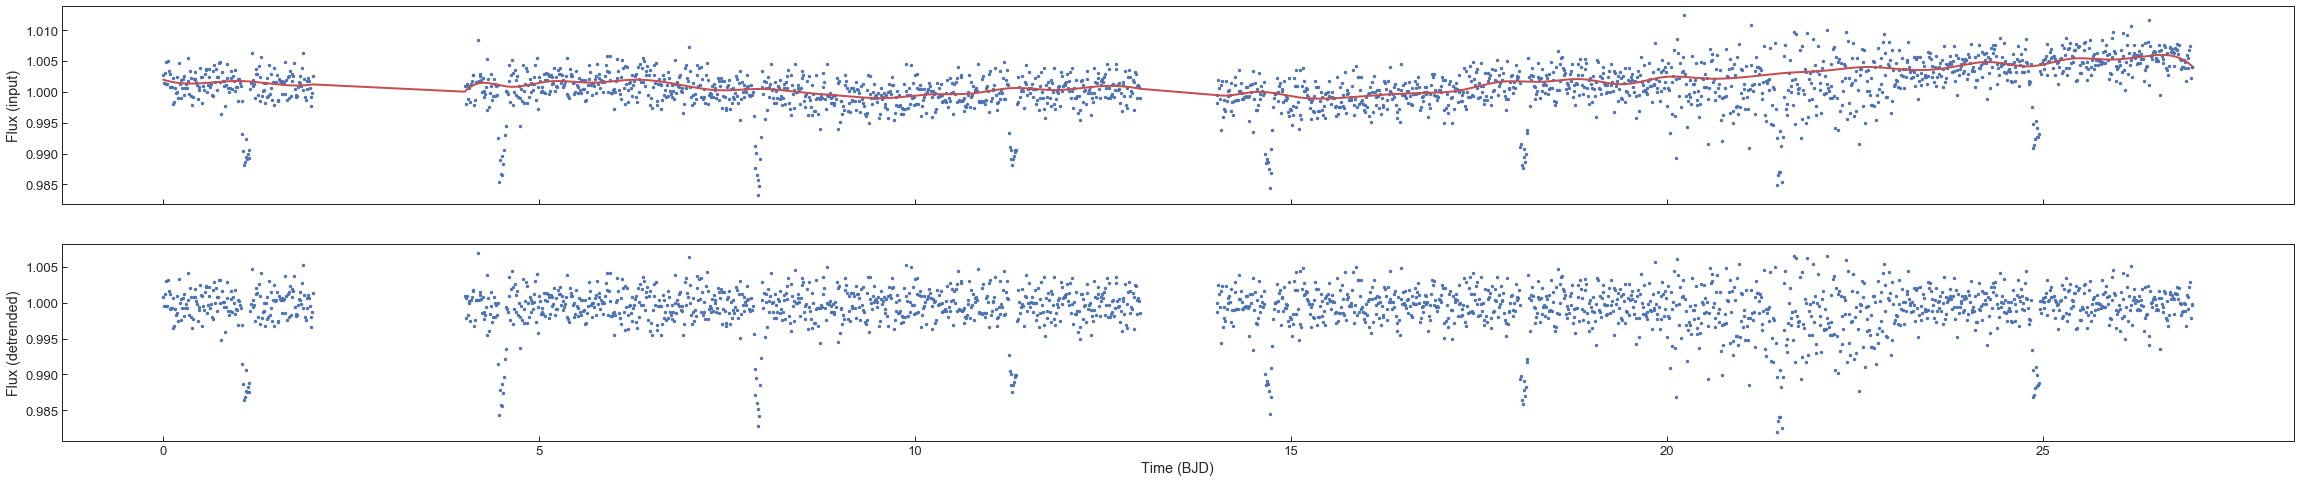

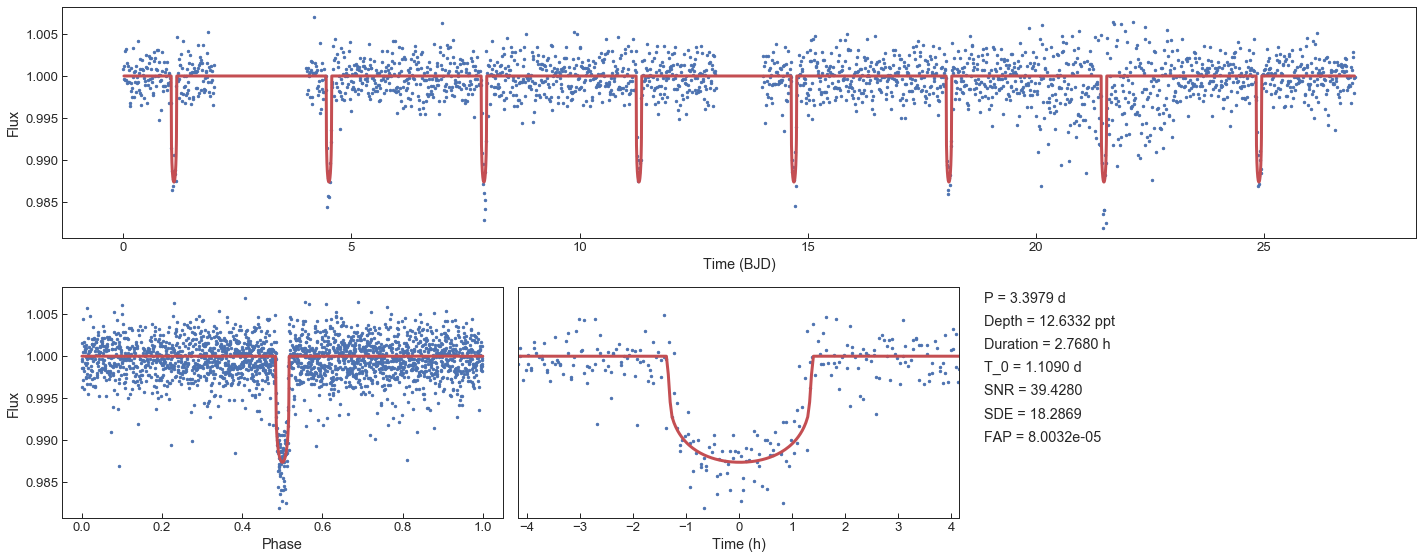

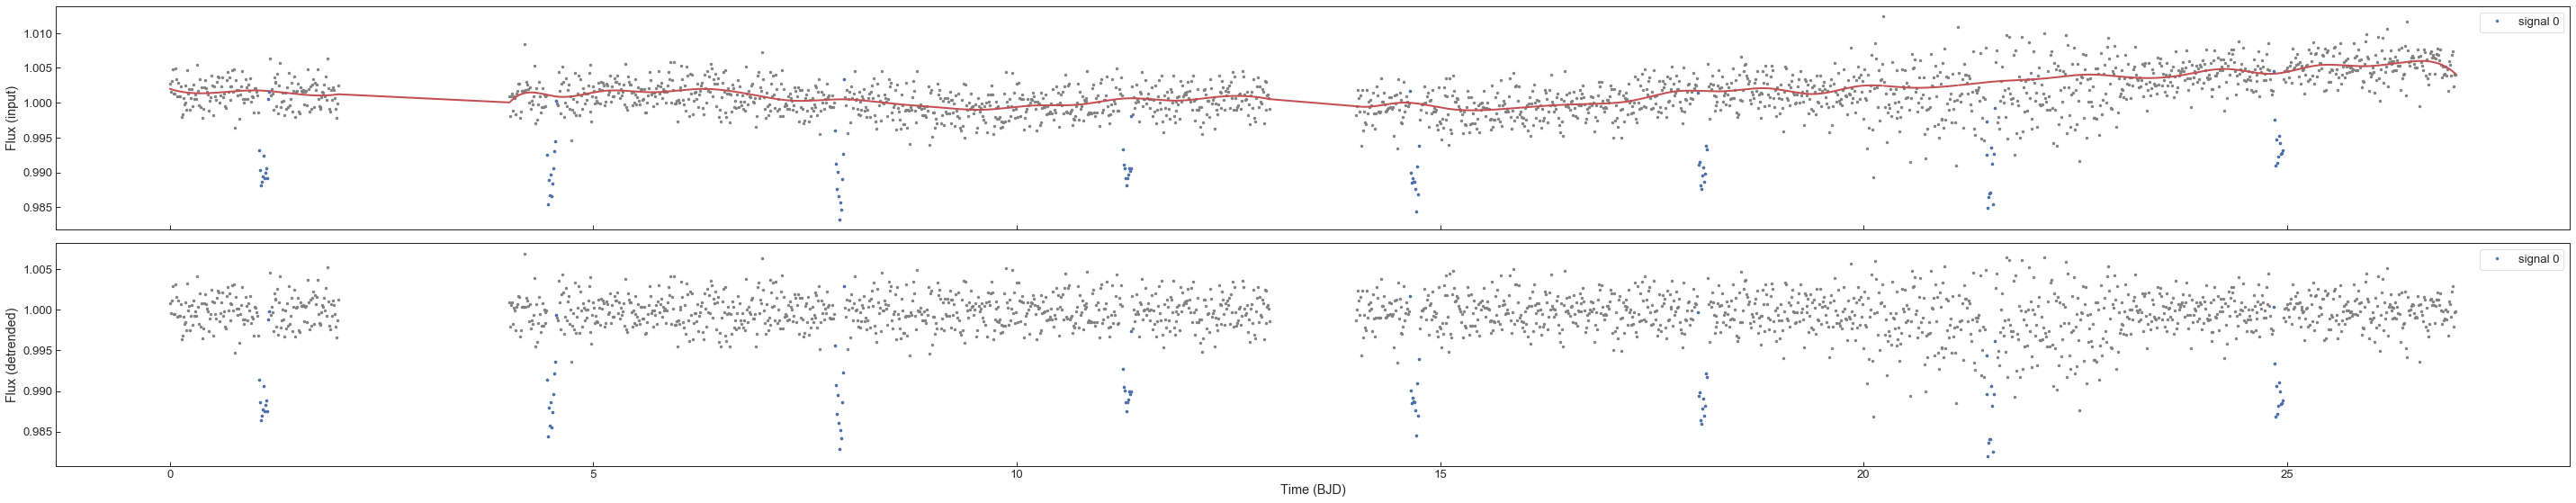

In [9]:
flatten = {'method':'rspline', 
           'window_length':0.5} 
wotan_kwargs = {'flatten':flatten}
tls_search(time, flux, flux_err, wotan_kwargs=wotan_kwargs);

Tada! So we can fine-tune the wotan detrending as we wish. For all options, please check the wotan docs! You will also find that this created a new results folder for you, named after the detrending settings. 

### 3.3) But what about flares and outliers?

"But what do we do if there are flares or other outliers?" you rightfully ask.
Fear not! The 'default' options take care of that:

In [10]:
slide_clip = {'window_length':1, #a 1 day sliding window
              'high':3, #for outliers 3 sigma above the median
              'low':20} #for outliers 20 sigma below the median

And you can still fine-tune even those:

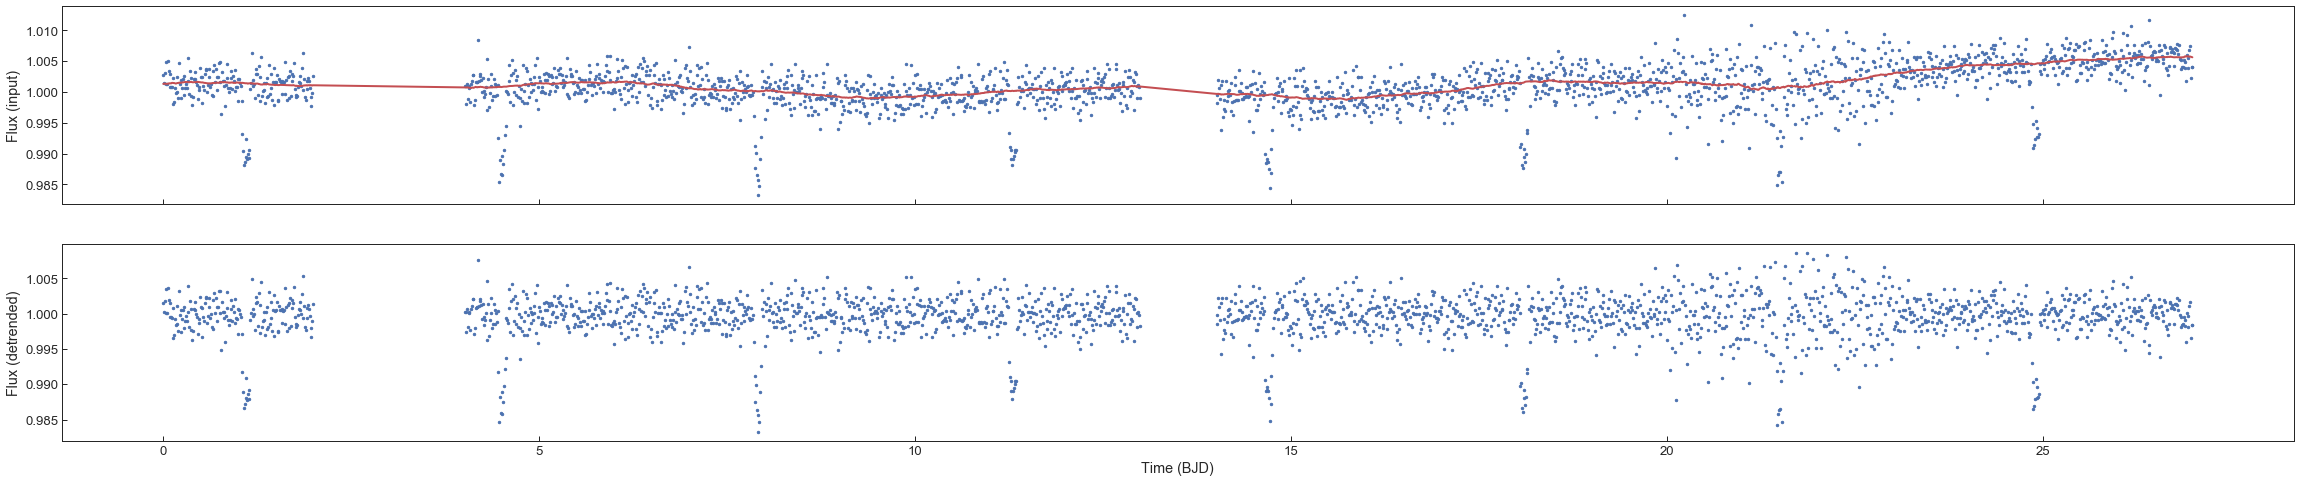

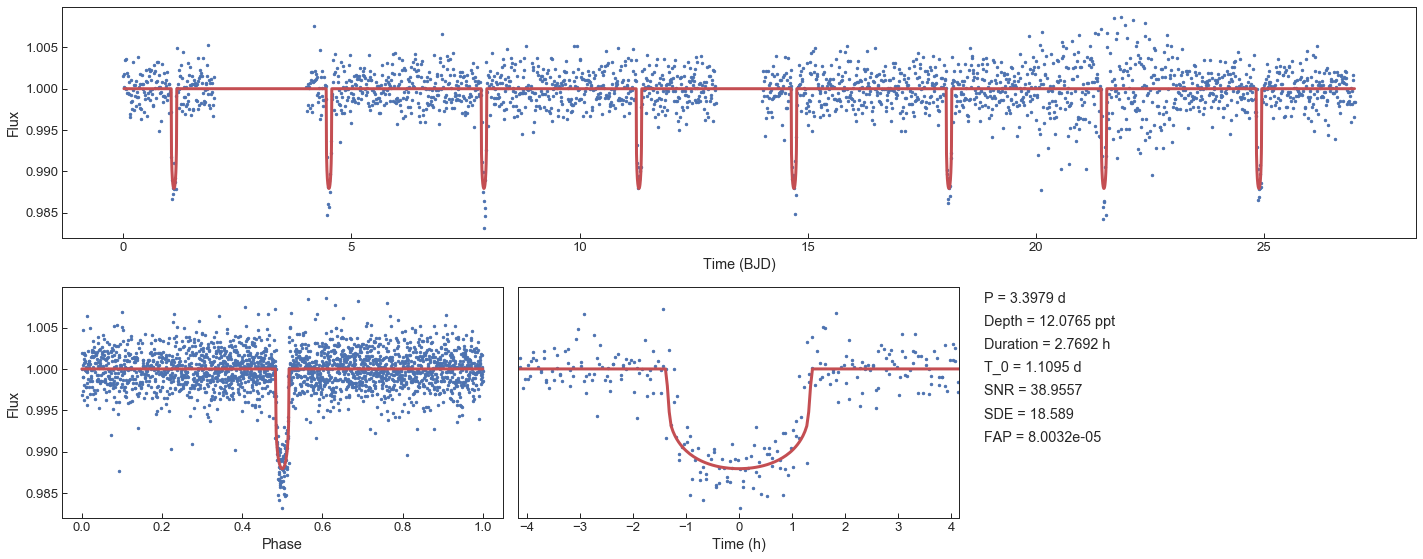

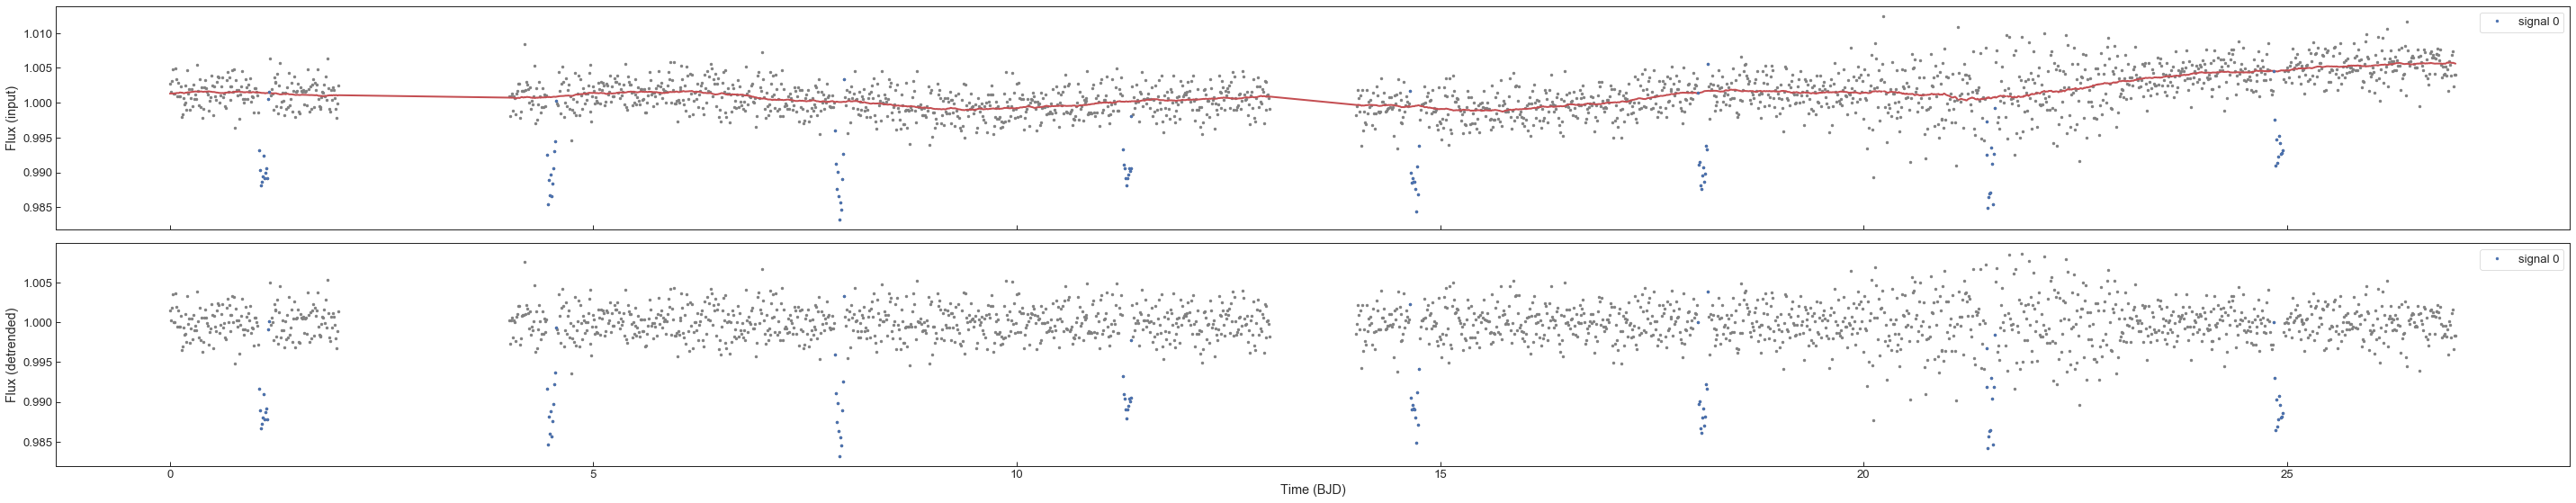

In [11]:
slide_clip = {'window_length':0.5,
              'high':3,
              'low':10}
wotan_kwargs = {'slide_clip':slide_clip}
tls_search(time, flux, flux_err, wotan_kwargs=wotan_kwargs);

### 3.4) Fine-tuning the general options (file names, what to save, etc.)

You can, of course, fine-tune what you want to save and under which names. The defaults are:

In [12]:
options = {'show_plot':True,
           'save_plot':True,
           'save_csv':True,
           'outdir':None, #defaults to tls_results_[flatten_method]_[flatten_window_length]
           'quiet':False}

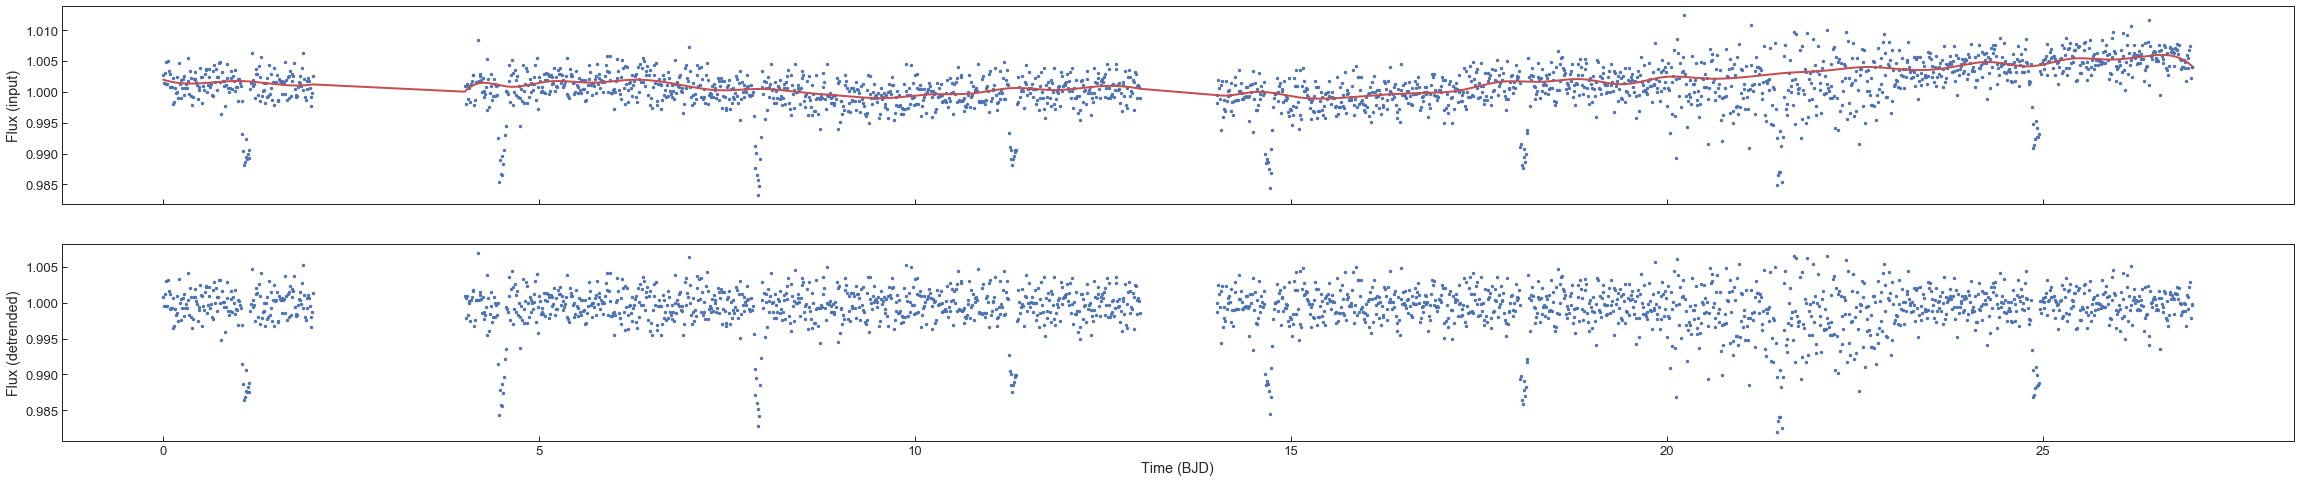

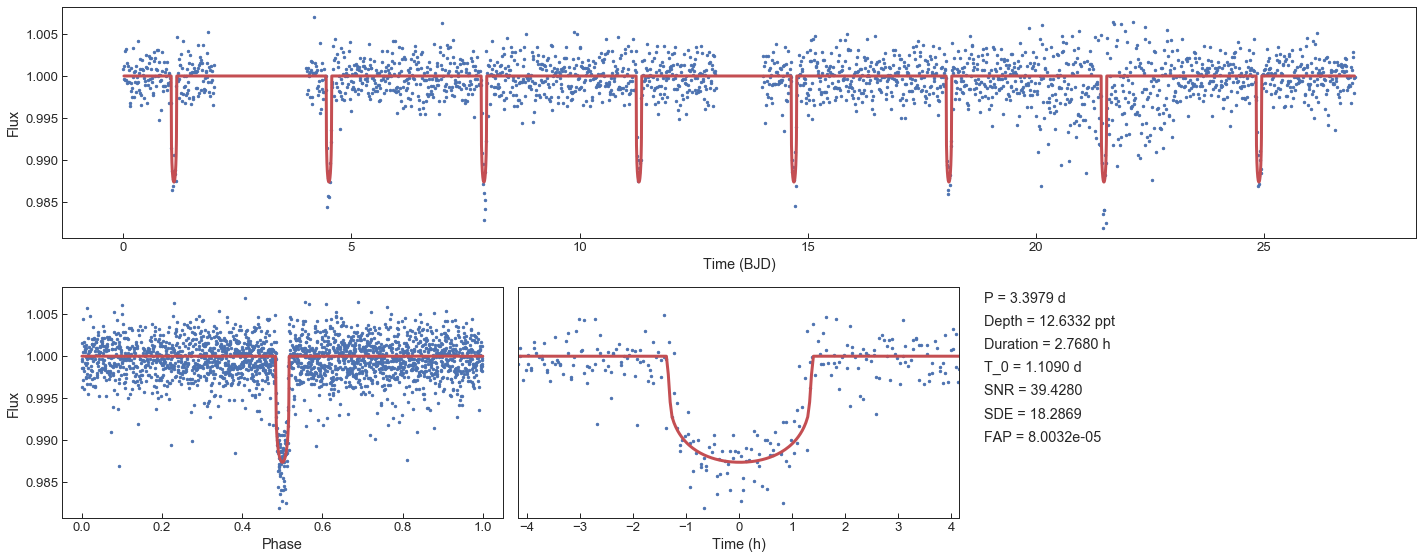

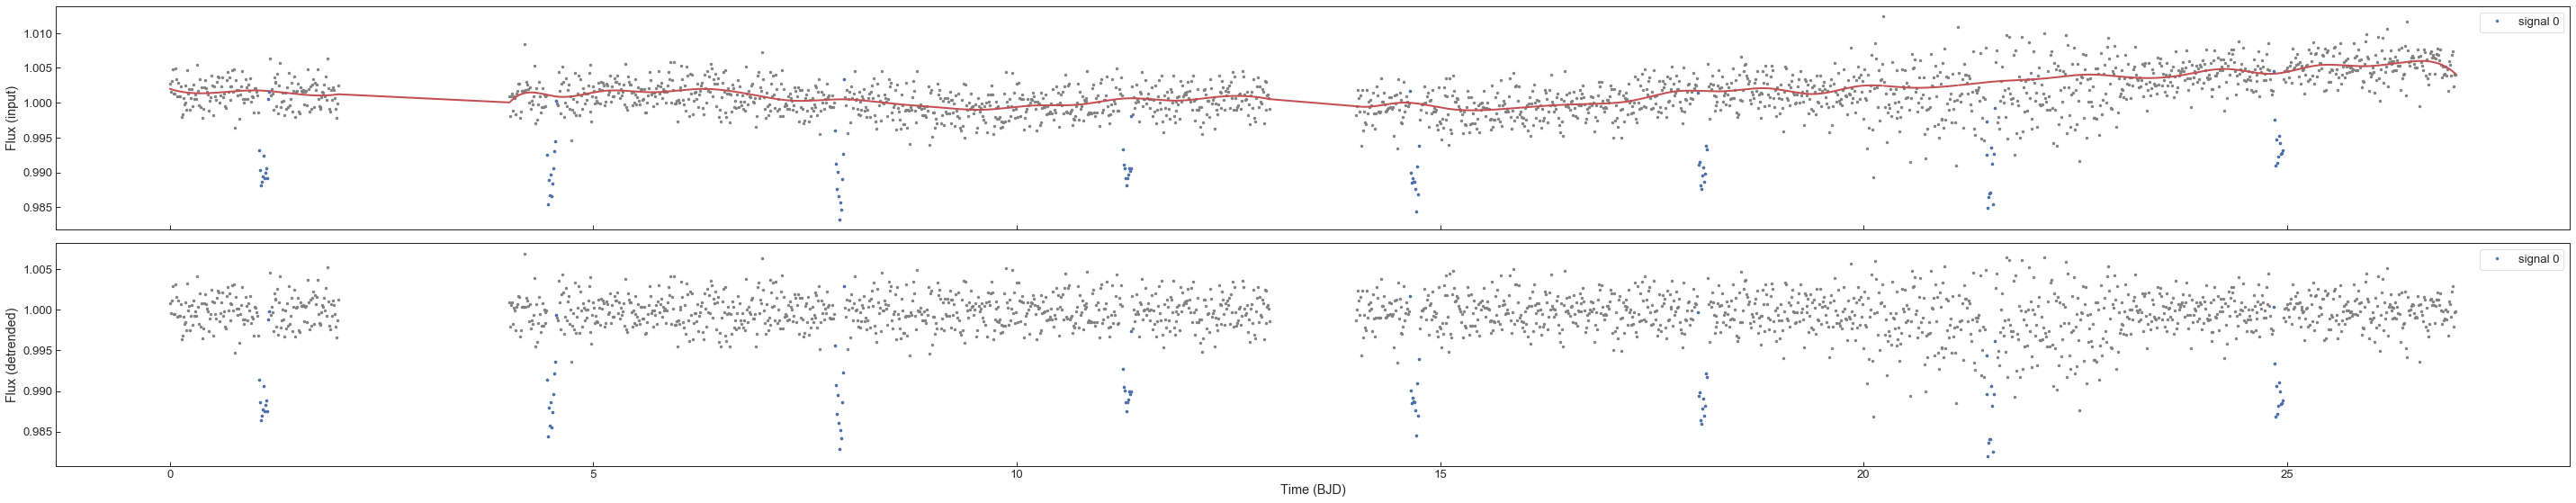

In [13]:
# Let's bring it all together, in an ultimate and unneccessary fine-tuning effort!

flatten = {'method':'rspline', 
           'window_length':0.5} 
wotan_kwargs = {'flatten':flatten}
tls_search(time, flux, flux_err, wotan_kwargs=wotan_kwargs);
